# Bayesian blocks for light curves and histograms

Bayesian blocks are an effective way to bin inhomogenous data, while strengthening the signal in bins with low signal/small values, but keeping sensitivity to high resolution in high SNR regions.

These scribbles here are based on:
- [Scargle et al. 2012](https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S/abstract)
- [This nice intro by Jake VanderPlas](https://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/)
- [Bayesian blocks in Astropy](https://docs.astropy.org/en/stable/api/astropy.stats.bayesian_blocks.html)
- [Histogram binning in Astropy](https://docs.astropy.org/en/stable/visualization/histogram.html#bayesian-models)

In [1]:
import palettable
import numpy as np
from astropy.io import fits, ascii
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
colorset = palettable.cubehelix.cubehelix3_16.hex_colors

In [2]:
%matplotlib notebook

In [3]:
def bayesian_lc_binner(t,y,dy,fitness):
    """
    Producing a binned LC using Bayesian blocks as implemented in Astropy
    
    Parameters:
    ----------
    t,y,dy: arrays of time, flux/rate/etc, and uncertainties
    
    fitness: the way to estimate bayesian fitness. See Astropy's bayesian block for more details.
    
    Returns:
    ----------
    binned_t, binned_dt, binned_y, binned_dy: binned arrays, binned_dt is half-binwidth
    
    """
    bblocks = bayesian_blocks(t,y,dy,fitness=fitness)

    t_bin = np.ndarray(len(bblocks)-1)
    dt_bin = np.ndarray(len(bblocks)-1)
    y_bin = np.ndarray(len(bblocks)-1)
    dy_bin = np.ndarray(len(bblocks)-1)
    
    for i_edge in range(len(bblocks)-1):
        block = [(t >= bblocks[i_edge]) & (t < bblocks[i_edge + 1])]
        t_bin[i_edge] = bblocks[i_edge] + (bblocks[i_edge+1]-bblocks[i_edge])/2.0
        dt_bin[i_edge] = (bblocks[i_edge+1]-bblocks[i_edge])/2.0
        y_bin[i_edge] = np.average(y[block],weights=dy[block]**-2)
        dy_bin[i_edge] = np.sum(dy[block]**2)**0.5
        
    return t_bin, dt_bin, y_bin, dy_bin

In [4]:
bat_data_path = 'https://swift.gsfc.nasa.gov/results/transients/weak/MAXIJ1820p070.lc.fits'
bat_data = fits.open(bat_data_path,cache=False)[1].data
lc_t, lc_y, lc_dy = bat_data['TIME'],bat_data['RATE'],bat_data['ERROR']

/home/arash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/arash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


<IPython.core.display.Javascript object>


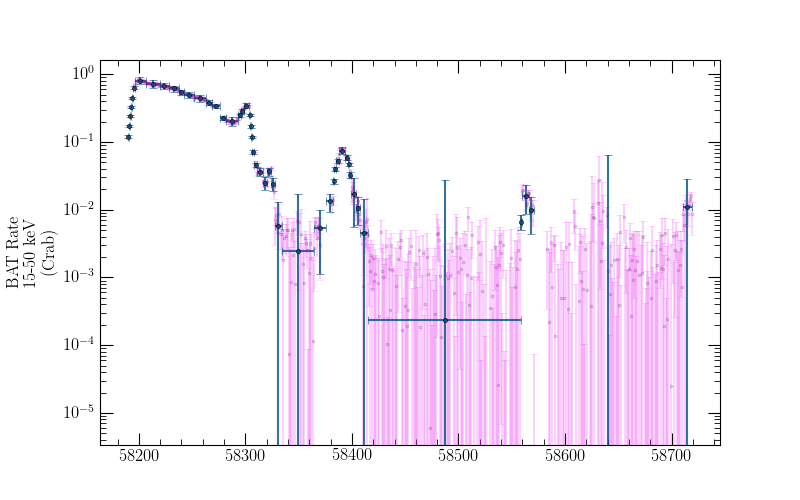

In [5]:
binned_lc_t, binned_lc_dt, binned_lc_y, binned_lc_dy = bayesian_lc_binner(lc_t, lc_y, lc_dy,'measures')

plt.figure(figsize=(8,5))
plt.errorbar(lc_t, lc_y, lc_dy,fmt='o',capsize=3,ms=2,alpha=0.2, markeredgecolor=colorset[0],color=colorset[7],markeredgewidth=0.5)
plt.errorbar(binned_lc_t, binned_lc_y, binned_lc_dy, binned_lc_dt,fmt='o',capsize=3,ms=3,alpha=0.8, markeredgecolor=colorset[0],color=colorset[3],markeredgewidth=0.5)

plt.ylabel('BAT Rate\n15-50 keV\n(Crab)',fontsize=12)
plt.yscale('log')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)

In [6]:
from astropy.visualization import hist
import scipy.stats as sts

<IPython.core.display.Javascript object>


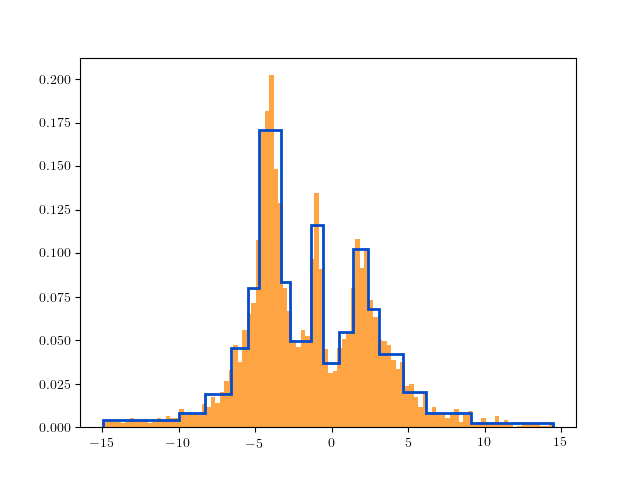

(array([0.0040306 , 0.00827125, 0.01881152, 0.04568746, 0.07978562,
        0.17071722, 0.08336583, 0.04985299, 0.11621194, 0.03672461,
        0.05479696, 0.10272144, 0.06797422, 0.04218643, 0.02026875,
        0.00801166, 0.00257444]),
 array([-14.97136966,  -9.97833787,  -8.30032639,  -6.5664823 ,
         -5.46272335,  -4.7379034 ,  -3.30025458,  -2.72032808,
         -1.33295032,  -0.56063308,   0.48496711,   1.39257178,
          2.36089893,   3.10617066,   4.68536101,   6.16901031,
          9.11405688,  14.5052249 ]),
 <a list of 1 Patch objects>)

In [7]:
np.random.seed(0)
rand_dist = np.concatenate([sts.cauchy(-5, 1.8).rvs(500),
                            sts.cauchy(-4, 0.8).rvs(2000),
                            sts.cauchy(-1, 0.3).rvs(500),
                            sts.cauchy(2, 0.8).rvs(1000),
                            sts.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
rand_dist = rand_dist[(rand_dist > -15) & (rand_dist < 15)]

plt.hist(rand_dist,bins=100,density=True, color=colorset[11])
hist(rand_dist, bins='blocks', histtype='step',density=True, color=colorset[4], linewidth=2)